# A metric for graph complexity and application to real complex networks

### Context

Consistently quantifying graph complexity is challenging since no single local metric recapitulates the "amount of structure" contained in a graph. However this is essential to capture how whole network complexity in natural systems scales with their size, interconnectedness etc. In their paper "A graph complexity measure based on the spectral analysis of the Laplace operator", authors define "spectral complexity", consistent with physical complexity (or apparent entropy), which increases under an initial potential when local structures are created, then is dissipated as thermal noise. 

The authors define the spectral complexity of a graph $G$ as $C_s(G)=\lVert \vec{\lambda_G}-\vec{\lambda_Z} \rVert . \lVert \vec{\lambda_G}-\vec{\lambda_F} \rVert$ where $F$ is the complete graph, $Z$ is the null graph and $\vec{\lambda}=(\lambda_1, ..., \lambda_N)$ is the spectrum of a graph. The spectrum is the eigenvalue vector of a matrix's Laplacian $\Delta=W-D$. If $Z$ is the null graph and $F$ is the complete graph, then $\lVert \vec{\lambda_Z} \rVert=(0,0,...,0)\in \mathbb{R}^n$ and $\lVert \vec{\lambda_F} \rVert=(0,N,..,N)\in \mathbb{R}^n$. Since the first eigenvalue $\lambda_1$ vanishes, we can rewrite the spectral complexity as $C_s(G)=\lVert \vec{\Lambda_G}-\vec{\Lambda_Z} \rVert . \lVert \vec{\Lambda_G}-\vec{\Lambda_F} \rVert$ (removed 1st eigenvalue from graph spectra) where $\vec{\Lambda_G}\in \mathbb{R}^{n-1}$, $\vec{\Lambda_Z}=(0,...,0)\in \mathbb{R}^{n-1}$ and $\vec{\Lambda_F}=(N,...,N)\in \mathbb{R}^{n-1}$

From these facts, the authors derive that $C_s(G)=\lVert \vec{\Lambda_G} \rVert.\lVert \vec{n}+\vec{\Lambda_G} \rVert$

In this notebook, I replicate their results and apply them to different real networks.

In [1]:
#import packages
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Example of spectral complexity for a random graph

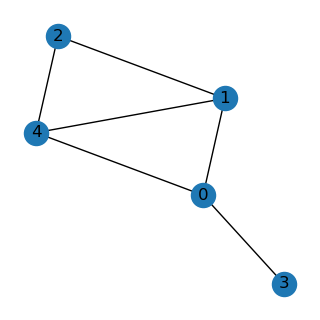

In [2]:
# Erdos Renyi random graph: 5 nodes, p=0.8
plt.figure(3,figsize=(3,3)) 
G=nx.erdos_renyi_graph(5,0.6)
nx.draw_kamada_kawai(G,with_labels=True)

In [3]:
#corresponding laplacian matrix
pd.DataFrame(nx.laplacian_matrix(G).toarray())

,0,1,2,3,4
0,3,-1,0,-1,-1
1,-1,3,-1,0,-1
2,0,-1,2,0,-1
3,-1,0,0,1,0
4,-1,-1,-1,0,3


In [4]:
#laplacian spectrum:
nx.laplacian_spectrum(G)

array([2.02615702e-15, 8.29913513e-01, 2.68889218e+00, 4.00000000e+00,
       4.48119430e+00])

In [5]:
#spectral complexity (based on previous definitions)

def norm(x): #l2 norm
    return np.linalg.norm(x)

def Cs(G,N): #spectral complexity of graph G with N nodes
    lG=nx.laplacian_spectrum(G)[1:]
    lF=N*np.ones(N-1)
    return norm(lG)*norm(lG-lF)

### Complexity as a function of link density

SPectral complexity is studied as a function of link density, defined as $\rho(G)=\frac{2m}{n(n-1)}$ where $m$ is the actual number of edges and ${n \choose 2}=\frac{n(n-1)}{2}$ is the number of possible edges (ie number of edges in the complete graph of size n).

In [77]:
def linking_density(G,N): #linking density for a graph G with N nodes
    return 2*nx.number_of_edges(G)/(N*(N-1))

Let's see how $C_s(G)$ varies with linking density $\rho$ in the simple case of random Erdos-Renyi networks.

Text(0, 0.5, 'Spectral complexity')

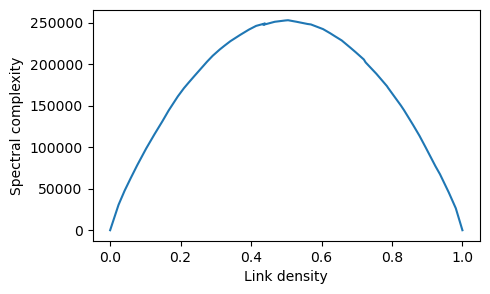

In [78]:
N=100 #fixed number of egdes

fig=plt.figure(figsize=(5,3))

p=np.linspace(0,1,50) #linking probabilities
LD=[] #link density list
C=[] #spectral complexity list

for i in p:
    G=nx.erdos_renyi_graph(N,i)
    C.append(Cs(G,N))
    LD.append(linking_density(G,N))
plt.plot(LD,C)
plt.xlabel("Link density")
plt.ylabel("Spectral complexity")

We find that for a range of linking probabilities, spectral complexity is distributed as a bell-shaped curve with a maximum at $\rho=0.5$.

# Temporal evolution in a random graph

By physical analogy, we can define thermodynamic properties in a graph: a potential/probability $p=1-\rho$ (linking density) and complexity $C_s(G)$ (apparent entropy)

In [141]:
N=20

ld=[0]
E=[1]
C=[0]

Z=np.zeros([N,N])
G=nx.from_numpy_array(Z)

for k in range(2000):
    i,j=int(np.random.rand()*N),int(np.random.rand()*N)
    if 1-ld[-1]>np.random.rand():
        G.add_edge(i,j)
    ld.append(2*nx.number_of_edges(G)/(N*(N-1)))
    E.append((1-ld[-1]))
    C.append(Cs(G,N))


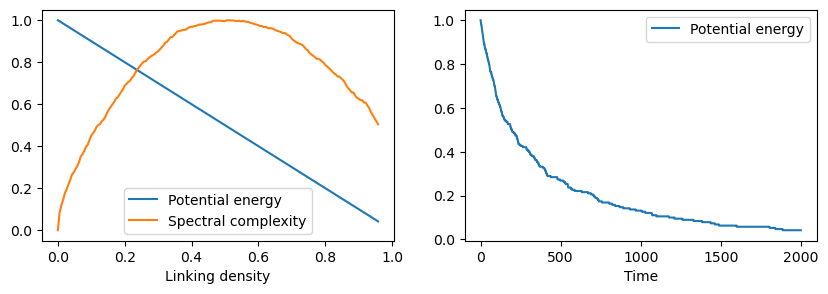

In [142]:
fig=plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(ld,E,label="Potential energy")
plt.plot(ld,C/np.max(C),label="Spectral complexity")
plt.xlabel("Linking density")
plt.legend()

plt.subplot(122)
time=list(range(2001))
plt.plot(time,1-np.array(ld),label="Potential energy")
plt.xlabel("Time")
plt.legend()


We find that graph complexity and energy evolve accordingly with simple thermodynamic principles: a potential drives graph evolution towards increasing linking densities, with complexity going through a maximum then decreasing. The potential driving this evolution also decreases in time as the graph reaches completeness (or equilibrium).

### Upper and lower bounds on graph complexity

Graph complexity seems to be bounded by graphs containing hubs (star-graphs, upper bound) and ring-like graphs (lower bound). This was determined empirically based on a large number of observations. The lower and upper bounds can be generated recursively (cf. paper). The lower bound is constructed by adding circles (diagonals in the matrix) and the upper bound is constructed by adding hubs (vertical and horizontal lines in the matrix)

In [143]:
#recursive definition

def upper(N): #returns the set of upper bound adjacency matrices  of order k, 0<k<N
    Z=np.zeros([N,N])
    U=[Z]
    for k in range(N-1):
        A=np.zeros([N,N])
        A[k,:]=np.ones(N)
        A=np.triu(A) #keep upper triangle
        np.fill_diagonal(A,0) #set main diagonal to 0
        A=A+np.transpose(A)#get symmetrical matrix
        U.append(U[-1]+A)
    return U

def lower(N):
    L=[np.zeros([N,N])]
    for k in range(int(N/2)): 
        A=np.triu(np.ones([N,N]),k+1)-np.triu(np.ones([N,N]),k+2) #fill diagonals
        B=np.triu(np.ones([N,N]),N-k-1)-np.triu(np.ones([N,N]),N-k)
        L.append(L[-1]+A+B+np.transpose(A+B)) #add both diagonals and transpose  
    if N%2==0: #correct for even N
        l=L[-1]
        l[l!=0]=1
        L[-1]=l
        
    return L

#singular definition:

def upper_k(N,k):
    A=np.zeros([N,N])
    for i in range(k):
        A[i,:]=np.ones(N)
    A=np.triu(A) #keep upper triangle
    np.fill_diagonal(A,0) #set main diagonal to 0
    A=A+np.transpose(A)#get symmetrical matrix
    return A

def lower_k(N,k): #k<N/2
    Z=np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if j-i>N-k-1: #central diagonal of rank k
                Z[i,j]=1
            if j-i<k+1: #corner diagonal of rank k
                Z[i,j]=1
    np.fill_diagonal(Z,0)
    Z=np.triu(Z)
    Z=Z+np.transpose(Z)
    
    return Z

In [144]:
def plotgraphs(G1,G2,G3,N):
    fig=plt.figure(figsize=(10,3))
    plt.subplot(131,title="Link density "+str(round(linking_density(G1,N),2)))
    nx.draw(G1,node_size=20, alpha=0.2)
    plt.subplot(132,title="Link density "+str(round(linking_density(G2,N),2)))
    nx.draw(G2,node_size=20, alpha=0.2)
    plt.subplot(133,title="Link density "+str(round(linking_density(G3,N),2)))
    nx.draw(G3,node_size=20, alpha=0.2)
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


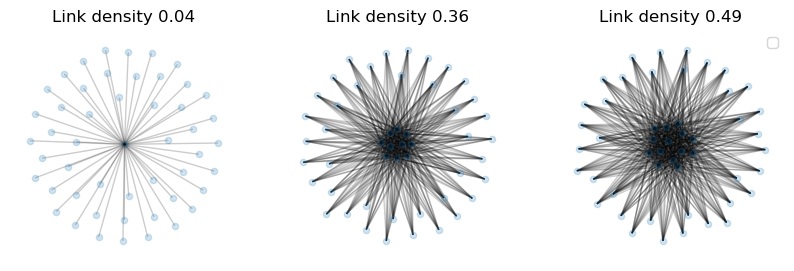

In [145]:
#Upper bound graphs
U=upper(50)

Gu1=nx.from_numpy_array(U[1])
Gu2=nx.from_numpy_array(U[10])
Gu3=nx.from_numpy_array(U[14])

plotgraphs(Gu1,Gu2,Gu3,50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


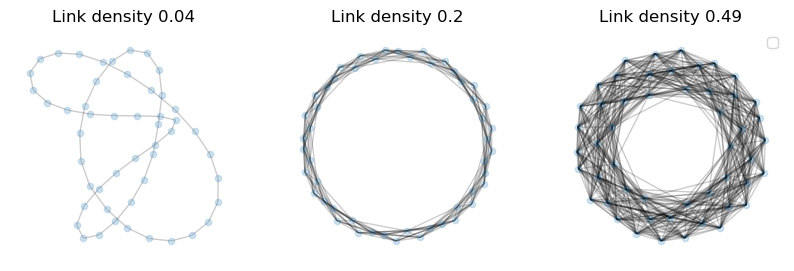

In [146]:
#lower bound circular graphs
L=lower(50)
#k<N/2
Gl1=nx.from_numpy_array(L[1])
Gl2=nx.from_numpy_array(L[5])
Gl3=nx.from_numpy_array(L[12])

plotgraphs(Gl1,Gl2,Gl3,50)

We confirm that the bounding graph morphologies correspond to graphs with an increasing number of hubs (upper) or circle layers (lower).

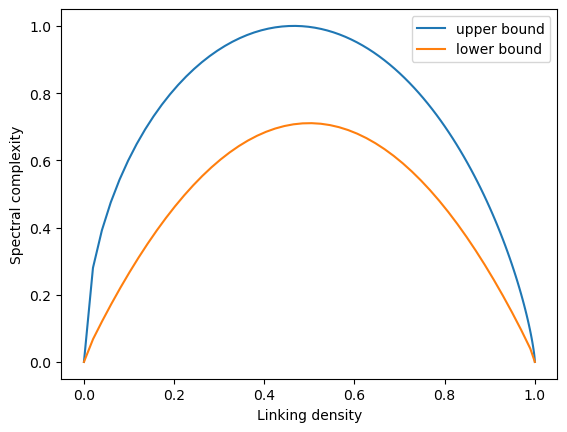

In [147]:
def bound_complexity(N):
    U=upper(100)
    L=lower(100)

    Cu=[]
    Cl=[]
    LDu=[]
    LDl=[]
    for x in U:
        Gu=nx.from_numpy_array(x)
        Cu.append(Cs(Gu,N))
        LDu.append(linking_density(Gu,N))
    for y in L:
        Gl=nx.from_numpy_array(y)
        Cl.append(Cs(Gl,N))
        LDl.append(linking_density(Gl,N))
        
    return Cu,Cl,LDu,LDl
    
def plot_bound_complexity(N):
    Cu,Cl,LDu,LDl=bound_complexity(N)
    plt.plot(LDu,Cu/np.max(Cu),label="upper bound")
    plt.plot(LDl,Cl/np.max(Cu),label="lower bound")
    plt.xlabel("Linking density")
    plt.ylabel("Spectral complexity")
    plt.legend()
    
    

plot_bound_complexity(100)

Let's find where the upper bounding graph achieves its maximum. We hypothesize that max complexity is achieved at k=N/4, corresponding on average to linking density $\rho=0.43$. We verify this up to N=100.

In [148]:
real_max=[] #real complexity maximum
h_max=[] #complexity of upper bound graph number N/4
h_ldmax=[] #linking density of graph N/4

for k in range(10,50):
    U=upper(k)
    Cupper=[]
    LD=[]
    
    for x in U:
        Gu=nx.from_numpy_array(x)
        Cupper.append(Cs(Gu,k))
        LD.append(linking_density(Gu,k))
        
    real_max.append(np.max(Cupper))
    h_max.append(Cs(nx.from_numpy_array(upper_k(k,int(k/4))),k))
    h_ldmax.append(linking_density(nx.from_numpy_array(upper_k(k,int(k/4))),k))

Text(0, 0.5, 'Linking density of most complex graph')

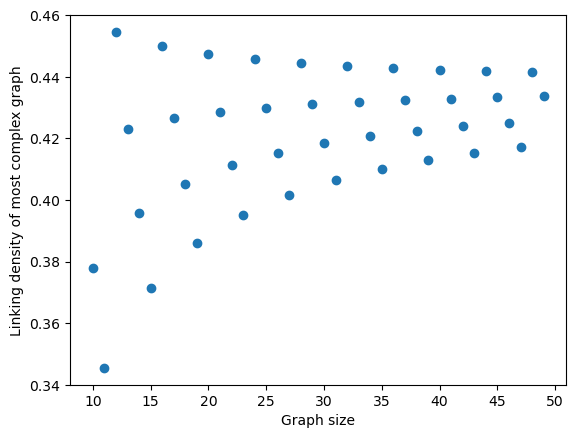

In [149]:
plt.scatter(list(range(10,50)),h_ldmax)
plt.xlabel("Graph size")
plt.ylabel("Linking density of most complex graph")

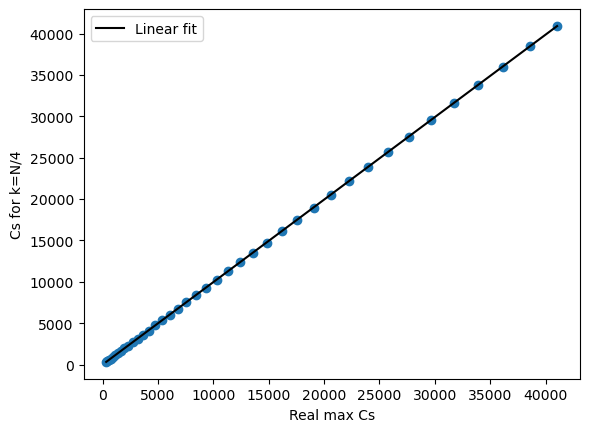

In [150]:
a,r=np.polyfit(real_max,h_max,1)
plt.scatter(real_max,h_max)
linspace=np.linspace(np.min(real_max),np.max(real_max))
plt.xlabel("Real max Cs")
plt.ylabel("Cs for k=N/4")
plt.plot(linspace,linspace*a,color="k",label="Linear fit")
plt.legend()

Let's test how different classes of graph generative models fit between these boundaries. It is very important to normalize complexity as it depends on graph size: we will just have to use the N/4th graph in the upper boundary as it reaches max complexity.

In [151]:
#erdos-renyi
Cer=[]
Ler=[]
for p in np.linspace(0,1,20):
    G=nx.erdos_renyi_graph(100,p)
    Cer.append(Cs(G,100))
    Ler.append(linking_density(G,100))

#Watts-Strogatz
Cws=[]
Lws=[]

for k in range(2,100,5):
    for p in np.linspace(0,1,10):
        G=nx.watts_strogatz_graph(100, k, p)
        Cws.append(Cs(G,100))
        Lws.append(linking_density(G,100))
        
#Barabasi_albert
Cba=[]
Lba=[]
for l in range(1,100):
    G=nx.barabasi_albert_graph(100, l)
    Cba.append(Cs(G,100))
    Lba.append(linking_density(G,100))

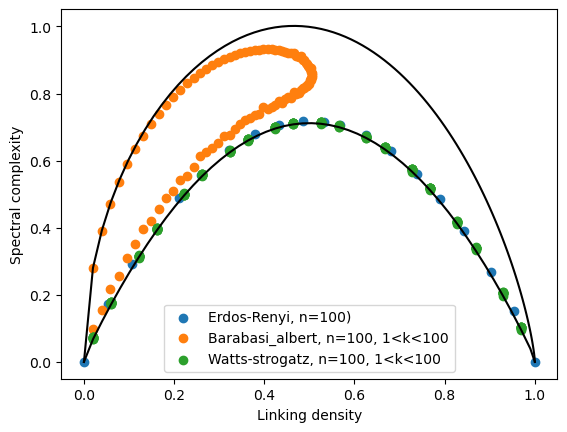

In [152]:
#Normalization
cmax=Cs(nx.from_numpy_array(upper_k(100,25)),100)
Cu,Cl,LDu,LDl=bound_complexity(100)

plt.scatter(Ler,Cer/cmax,label="Erdos-Renyi, n=100)")
plt.scatter(Lba,Cba/cmax,label="Barabasi_albert, n=100, 1<k<100")
plt.scatter(Lws,Cws/cmax,label="Watts-strogatz, n=100, 1<k<100")
plt.plot(LDu,Cu/cmax,color="k")
plt.plot(LDl,Cl/cmax,color="k")
plt.xlabel("Linking density")
plt.ylabel("Spectral complexity")
plt.legend()

Let's take a closer look at these diferent models to check if their architecture corresponds to their place in the complexity-density distribution.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


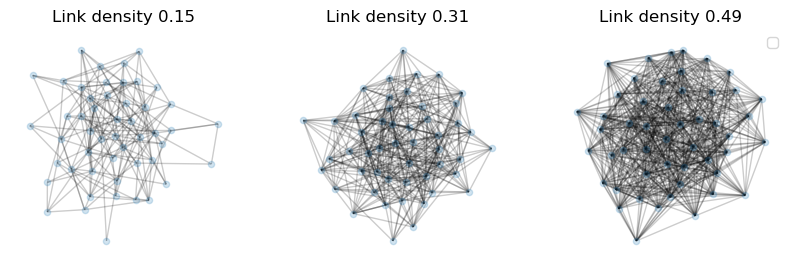

In [153]:
#Erdos-renyi graphs
Ger1=nx.erdos_renyi_graph(50,0.15)
Ger2=nx.erdos_renyi_graph(50,0.3)
Ger3=nx.erdos_renyi_graph(50,0.5)

plotgraphs(Ger1,Ger2,Ger3,50)

In the Erdos-Renyi model, the expected number of edges $m$ is $p {n \choose 2}=p\frac{n(n-1)}{2}$, so given the definition of the linking density, we have $\rho_{ER}=p$. These graphs look mostly organized with local loops, which brings them close to lower bound graphs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


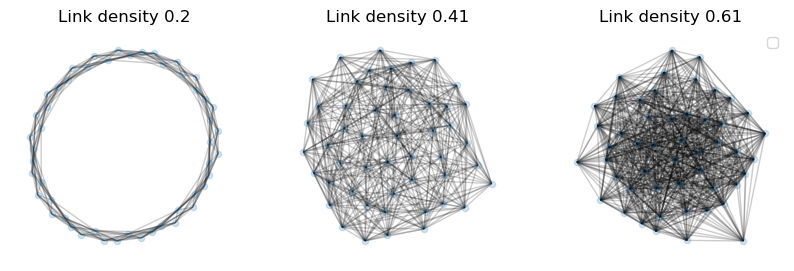

In [95]:
#Watts-strogatz graphs
Ger1=nx.watts_strogatz_graph(50,10,0)
Ger2=nx.watts_strogatz_graph(50,20,0.2)
Ger3=nx.watts_strogatz_graph(50,30,0.5)

plotgraphs(Ger1,Ger2,Ger3,50)

Watts-Strogatz graphs can be made to look like lattices or like Erdos-Renyi graphs by varying the rewiring probability $p$ and the mean degree $K$, but both these structures are full of internal loops, so WS graphs also cluster towards the lower bound.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


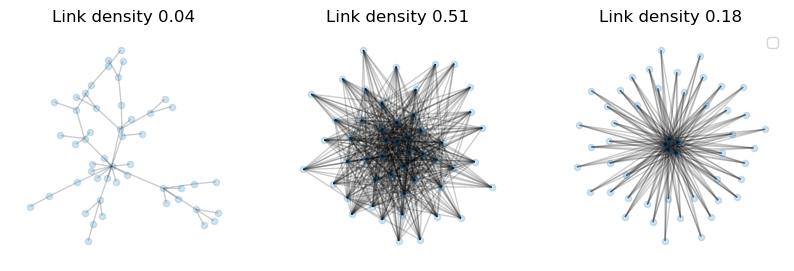

In [96]:
#Barabasi albert graphs
Gba1=nx.barabasi_albert_graph(50,1)
Gba2=nx.barabasi_albert_graph(50,25)
Gba3=nx.barabasi_albert_graph(50,45)

plotgraphs(Gba1,Gba2,Gba3,50)

In a BA network, there is a dynamic balance between hubs and circles, which is consistent with reals networks: hubs are important organizers/effectors and circles often correspond to control motifs (feedforward, feedback etc). This is why BA networks explore more complexity/density spaces than other random graphs.

### Application to real networks

In [154]:
path="/home/hugo/Documents/Codes/Complex_nets/"
files="coli_grn.txt","electronic_circuit.txt","yeast_grn.txt"

def import_graph(path,file): #get undirected graph from txt file edge list
    #load file as dataframe
    df=pd.read_csv(path+file, sep=" ", header=None)
    df=df.drop([2], axis=1) #remove edge direction
    G=nx.from_edgelist(pd.DataFrame.to_numpy(df))
    l_cc = max(nx.connected_components(G), key=len) #get nodes in largest component
    #get largest component
    H=[]
    for x in G.edges():
        if x[0] in l_cc:
            H.append(x)
    G = nx.from_edgelist(H)
    return G


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


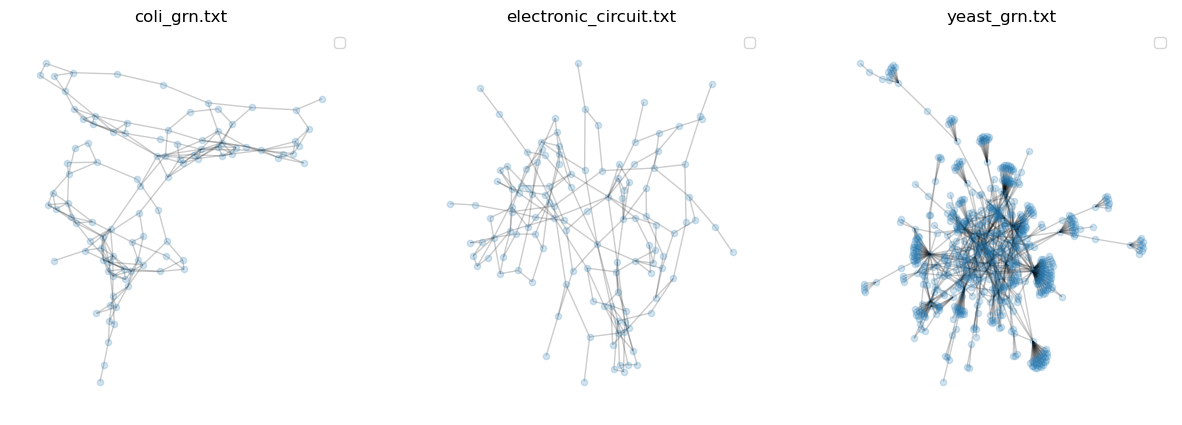

In [155]:
#draw networks and get their normalized complexity and linking density

l=[]
c=[]
n_nodes=[]

fig=plt.figure(figsize=(15,5))

for i in range(3):
    G=import_graph(path,files[i])
    N=nx.number_of_nodes(G)
    n_nodes.append(N)
    cmax=Cs(nx.from_numpy_array(upper_k(N,int(N/4))),N)
    l.append(linking_density(G,N))
    c.append(Cs(G,N)/cmax)
    plt.subplot(130+i+1,title=str(files[i]))
    nx.draw(G,node_size=20, alpha=0.2)
    plt.legend()
plt.show()

In [156]:
nmax=100 #bounding graphs
cu,cl,ldu,ldl=bound_complexity(nmax)
cmax=np.max(cu)

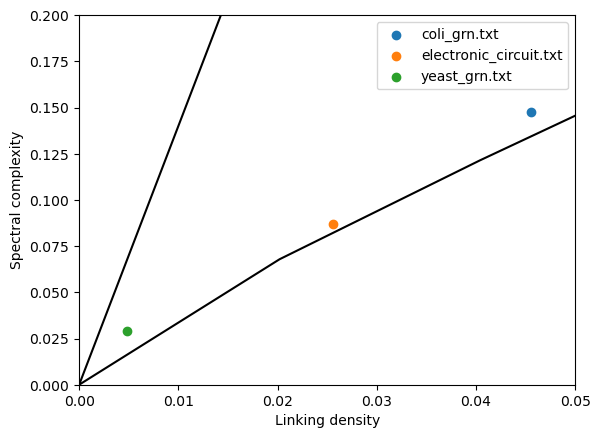

In [160]:


fig, ax = plt.subplots()

ax.plot(ldu,cu/cmax,color="k")
ax.plot(ldl,cl/cmax,color="k")

for i in range(len(files)):
    ax.scatter(l[i],c[i],label=files[i])

ax.set_xlim(0,0.05)
ax.set_ylim(0,0.2)
plt.xlabel("Linking density")
plt.ylabel("Spectral complexity")
plt.legend()

We find that in real networks, spectral complexity stays low overall. Interestingly, this refelcts the sparse nature of real networks: maintaining many interactions in a network is energetically costly, so natural systems tend to adjust sub-optimally. Also, small real networks cluster close to the lower bound as they display mostly control elements (ie: internal loops) and few islated effectors (hubs connected to leafs).

### Spectral complexity in network core

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


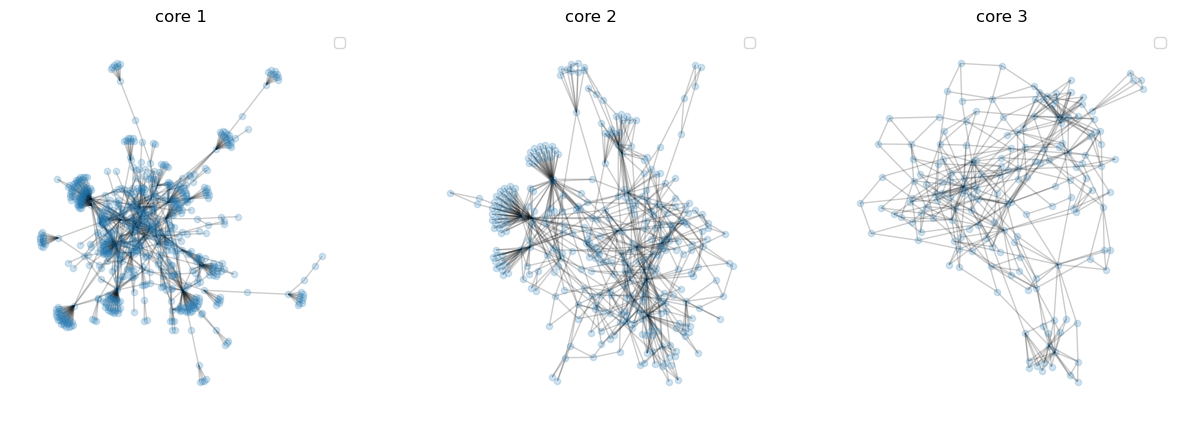

In [161]:
G=import_graph(path,"yeast_grn.txt")

l=[]
c=[]
n_nodes=[]

fig=plt.figure(figsize=(15,5))

for i in range(1,4):
    H=nx.k_core(G,i) #subgraph of G with nodes of degree i or more
    N=nx.number_of_nodes(H)
    n_nodes.append(N)
    cmax=Cs(nx.from_numpy_array(upper_k(N,int(N/4))),N)
    l.append(linking_density(H,N))
    c.append(Cs(H,N)/cmax)
    plt.subplot(130+i,title="core "+str(i))
    nx.draw(H,node_size=20, alpha=0.2)
    plt.legend()
plt.show()

In [163]:
nmax=100 #bounding graphs
cu,cl,ldu,ldl=bound_complexity(nmax)
cmax=np.max(cu)

Text(0, 0.5, 'Spectral complexity')

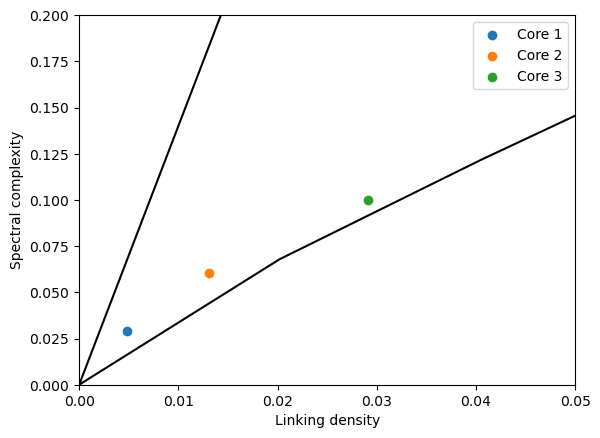

In [164]:
fig, ax = plt.subplots()

ax.plot(ldu,cu/cmax,color="k")
ax.plot(ldl,cl/cmax,color="k")

for i in range(3):
    ax.scatter(l[i],c[i],label="Core "+str(i+1))

plt.legend()
ax.set_xlim(0,0.05)
ax.set_ylim(0,0.2)
ax.set_xlabel("Linking density")
ax.set_ylabel("Spectral complexity")